# MelanomAI

A Deep CNN to classify three different type of skin cancer, like melanomas

## Set up Google Colab 

In [0]:
from google.colab import drive 
drive.mount('/betogdrive')

In [9]:
%cd ./../betogdrive/My Drive/app/Disease-Classification
%ls

/betogdrive/My Drive/app/Disease-Classification
data/  Get-remote-data.ipynb  MelanomAI.ipynb


In [0]:
!pip3 install torch torchvision

In [18]:
! which pip
! /usr/local/bin/pip uninstall pip
! apt-get update
! apt-get install python3-pip
! pip3 install --upgrade pip
! pip3 install pillow
! pip3 install torch torchvision

  Using cached https://files.pythonhosted.org/packages/d1/24/f53ff6b61b3d728b90934bddb4f03f8ab584a7f49299bf3bde56e2952612/Pillow-5.2.0-cp36-cp36m-manylinux1_x86_64.whl


## Imports 

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.functional as F
from torch import optim
from torchvision import datasets, transforms, models
from collections import OrderedDict

## Explore data 

In [18]:
import glob 
import cv2

paths = ["data/train/melanoma", 
         "data/train/nevus",
         "data/train/seborrheic_keratosis"]

img_paths = []

# Get a sample of 15 training images (5 for each class)
for i in range(3):
  cont = 0
  for file in glob.glob(paths[i]+"/*.jpg"):
    img_paths.append(file)
    if cont == 4:
      break
    cont +=1 
      
print(len(img_paths))
print(img_paths)

15
['data/train/melanoma/ISIC_0010034.jpg', 'data/train/melanoma/ISIC_0014795.jpg', 'data/train/melanoma/ISIC_0010194.jpg', 'data/train/melanoma/ISIC_0015166.jpg', 'data/train/melanoma/ISIC_0014163.jpg', 'data/train/nevus/ISIC_0009938.jpg', 'data/train/nevus/ISIC_0011300.jpg', 'data/train/nevus/ISIC_0013120.jpg', 'data/train/nevus/ISIC_0000546.jpg', 'data/train/nevus/ISIC_0009914.jpg', 'data/train/seborrheic_keratosis/ISIC_0013731.jpg', 'data/train/seborrheic_keratosis/ISIC_0012719.jpg', 'data/train/seborrheic_keratosis/ISIC_0012103.jpg', 'data/train/seborrheic_keratosis/ISIC_0014628.jpg', 'data/train/seborrheic_keratosis/ISIC_0014650.jpg']


In [19]:
# Read images 
images = []
for path in img_paths: 
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  images.append(image)

# Check if images has the same shape
for i in range(len(images)):
  print("image: ", i, " has shape: ", images[i].shape)

image:  0  has shape:  (768, 1024, 3)
image:  1  has shape:  (4420, 6641, 3)
image:  2  has shape:  (768, 1024, 3)
image:  3  has shape:  (4459, 6627, 3)
image:  4  has shape:  (2848, 4288, 3)
image:  5  has shape:  (768, 1024, 3)
image:  6  has shape:  (768, 1024, 3)
image:  7  has shape:  (2592, 3872, 3)
image:  8  has shape:  (719, 824, 3)
image:  9  has shape:  (768, 1024, 3)
image:  10  has shape:  (2592, 3872, 3)
image:  11  has shape:  (2000, 3008, 3)
image:  12  has shape:  (2000, 3008, 3)
image:  13  has shape:  (1936, 2592, 3)
image:  14  has shape:  (1936, 2592, 3)


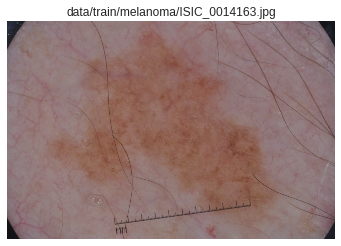

In [32]:
# Visualize image
index = 4

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title(img_paths[index])
ax1.imshow(images[index])

## Check model architecture for transfer learning

In [55]:
model = models.inception_v3(pretrained=True)
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

## Load data

In [0]:
root_path = "data/"

normalize = transforms.Normalize(
   mean=[0.5, 0.5, 0.5],
   std=[0.5, 0.5, 0.5]
)

train_transforms = transforms.Compose([transforms.Resize(360),
                                       transforms.RandomResizedCrop(299),
                                       transforms.ToTensor(),
                                       normalize])
"""
train_data = datasets.ImageFolder(root_path+'train', transform=train_transforms)
valid_data = datasets.ImageFolder(root_path+'valid', transform=train_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)"""

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                         shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

## Build model

### Freeze parameters of inception-v3

In [0]:
for parameters in model.parameters():
  parameters.requires_grad = False 

### Create the classifier

In [0]:
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1024)),
                                         ('relu', nn.ReLU()),
                                         ('Drop1', nn.Dropout(0.4)),
                                         ('fc2', nn.Linear(1024, 512)),
                                         ('relu', nn.ReLU()),
                                         ('Drop2', nn.Dropout(0.5)),
                                         ('fc3', nn.Linear(512, 3)),
                                         ('output', nn.Softmax(dim=1))]))
# Replace inception-v3 classifier

in_features = model.fc.in_features
model.fc = nn.Linear(2048, 3, bias=True)

## Train classifier

### Check for GPU

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Check how much time will take on a simple batch

In [82]:
import time

criterion = nn.CrossEntropyLoss()
# Only train the classifier parameters, feature parameters are frozen
#ptimizer = optim.Adam(model.fc.parameters(), lr=0.001)
optimizer = optim.SGD(list(filter(lambda p: p.requires_grad, model.parameters())), lr=0.001, momentum=0.9)

model.to(device)
inputs, labels = next(iter(trainloader))
inputs, labels = inputs.to(device), labels.to(device)

start = time.time()

outputs, aux = model.forward(inputs)

loss = criterion(outputs, labels)
loss.backward()
optimizer.step()

print(f"Device = GPU; Time per batch: {(time.time() - start)/2:.3f} seconds")

Device = GPU; Time per batch: 0.038 seconds
